In [1]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_1618615d45cf46d6b2ac0ffc5768387a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='EmBKGm4pdJCoEKaaqhzEeQq7otSWi9F6NMg_vvvZnLmo',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

streaming_body_1 = client_1618615d45cf46d6b2ac0ffc5768387a.get_object(Bucket='cricketposeclassification-donotdelete-pr-x8lam4yk0mc1sp', Key='projectdata.zip')['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [2]:
ls -1

In [3]:
from io import  BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
file_path=unzip.namelist()
for path in file_path:
    unzip.extract(path)

In [4]:
pwd

'/home/wsuser/work'

In [5]:
#including the libraries
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
%matplotlib inline 
import numpy as np
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import PIL
import pathlib
from skimage.io import imread, imsave
from skimage import transform
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian

In [6]:
np.set_printoptions(suppress=True)

In [7]:
#this is used when we have have a zip file 
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# path = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [8]:
#makeing the size of the image default 
IMAGE_SHAPE = (256, 256)
path= '/home/wsuser/work/projectdata'

In [9]:
#converting the path to path lib path for easy to use
data_dir = pathlib.Path(path)
data_dir

PosixPath('/home/wsuser/work/projectdata')

In [10]:
list(data_dir.glob('*/*.jpg' ))[:5] #five image in */*.jpg in cut folder

[PosixPath('/home/wsuser/work/projectdata/drive/drive (13).jpg'),
 PosixPath('/home/wsuser/work/projectdata/drive/drive (1).jpg'),
 PosixPath('/home/wsuser/work/projectdata/drive/drive (24).jpg'),
 PosixPath('/home/wsuser/work/projectdata/drive/drive (2).jpg'),
 PosixPath('/home/wsuser/work/projectdata/drive/drive (25).jpg')]

In [11]:
#total image to test_and_train
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count) 

162


In [12]:
#listing the first five image of cut
cut= list(data_dir.glob('cut/*')) 
cut[:5]

[PosixPath('/home/wsuser/work/projectdata/cut/cut (18).jpg'),
 PosixPath('/home/wsuser/work/projectdata/cut/cut (12).jpg'),
 PosixPath('/home/wsuser/work/projectdata/cut/cut (6).jpg'),
 PosixPath('/home/wsuser/work/projectdata/cut/cut (2).jpg'),
 PosixPath('/home/wsuser/work/projectdata/cut/cut (5).jpg')]

# plotting the image

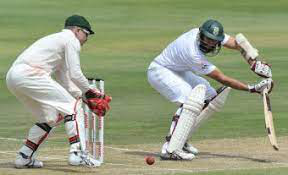

In [13]:
#ploting the image
PIL.Image.open(str(cut[7]))

In [14]:
#making a pose dict for easiy use of the path we get using the pathlib
pose_dict = {
    'cut': list(data_dir.glob('cut/*')),
    'sweep':list(data_dir.glob('sweep/*')),
    'drive':list(data_dir.glob('drive/*')),
    'fielding': list(data_dir.glob('fielding/*')),
    'bowling_action':list(data_dir.glob('bowling_action/*'))
}

In [15]:
#get the target variable with the help of class
pose_labels_dict = {
    'cut': 0,
    'sweep': 1,
    'drive': 2,
    'fielding': 3,
    'bowling_action': 4
}

In [16]:
#to convert the predicted output to the class name
class_labels_dict = {
    0:'cut',
    1:'sweep',
    2:'drive',
    3:'fielding',
    4:'bowling_action'
}

# ***data agmenetation working***

In [17]:
#data augmented for increasing the size of the data and making it more accurate
def data_append(img,pose):
    X.append(img)
    y.append(pose_labels_dict[pose_name])
def image_rotation(img,pose_name):
    #rotating the image
    rotate30 = rotate(img, angle=30)
    data_append(rotate30,pose_name)
    rotate45 = rotate(img, angle=45)
    data_append(rotate45,pose_name)
    rotate60 = rotate(img, angle=60)
    data_append(rotate60,pose_name)
    rotate90 = rotate(img, angle=90)
    data_append(rotate90,pose_name)
def data(img,pose_name):
    image_rotation(img,pose_name)

    rescaled = transform.rescale(img, 1.1) # Image rescaling with sklearn.transform.rescale
    data_append(rescaled,pose_name)
    image_rotation(rescaled,pose_name)

    up_down = np.flipud(img) # flip up-down using np.flipud
    data_append(up_down,pose_name)
    image_rotation(up_down,pose_name)

    left_right = np.fliplr(img) # flip right and left using np.flipud
    data_append(left_right,pose_name)
    image_rotation(left_right,pose_name)

    noised = random_noise(img, var=0.1**2) # Apply Random Noise to image using skimage.utils.random_noise
    data_append(noised,pose_name)
    image_rotation(noised,pose_name)

    highB = img + (100/255) # Increasing the brighness of the Image
    data_append(highB,pose_name)
    image_rotation(highB,pose_name)
    
    highC = img * 1.5 # Increasing the contrast of the Image
    data_append(highC,pose_name)
    image_rotation(highC,pose_name)

In [18]:
#storing the image(actual+augmented) in for of numpy array 
X=[]
y=[]
for pose_name, images in pose_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE) #it is bgr form so we have to convert it into rgb
        RGB_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        X.append(RGB_img)
        y.append(pose_labels_dict[pose_name])
        data(RGB_img,pose_name)

In [19]:
#total number of image (actual+augmented)
len(X)

5810

# ***using movenet for posedection***

In [20]:
#dictonary colour and the keypoint which is predicted by the move net
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [21]:
#used for display the key points on the image 
def _keypoints_and_edges_for_display(keypoints_with_scores,height,width,keypoint_threshold=0.11):
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors

In [22]:
#display the images 
def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

In [23]:
#loading and using the model 
module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

#function for prediction of the pose
def movenet(input_image):
  model = module.signatures['serving_default']
  input_image = tf.cast(input_image, dtype=tf.int32)
  outputs = model(input_image)
  keypoints_with_scores = outputs['output_0'].numpy()
  return keypoints_with_scores

In [24]:
#predicting the pose points for all the images and storing it into output
input_size=256
output=[]
for i in range(len(X)):
  image= tf. convert_to_tensor(X[i]) 
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  output.append(keypoints_with_scores)

In [25]:
#function for ploting the image and pose points
def img_show(image_pose_points,image_path_loc):
  if (type(image_path_loc)==str):
    '''if path is given'''
    image = tf.io.read_file(image_path_loc)
    image = tf.image.decode_jpeg(image)
  else:
    image=tf.convert_to_tensor(X[image_path_loc])
  '''if pos in x is given'''
  display_image = tf.expand_dims(image, axis=0)
  display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
  output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0),image_pose_points)

  plt.figure(figsize=(5,5))
  plt.imshow(output_overlay)
  _ = plt.axis('off')

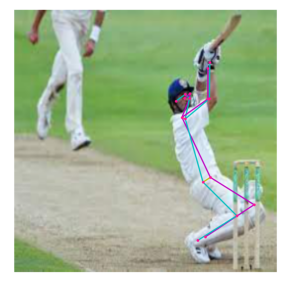

In [26]:
#ploting the 173 image of the X
p=0
img_show(output[p],p) 

# ***traning a nural network***

In [27]:
#converting the list to numpy array
output=np.array(output)
y=np.array(y)

In [28]:
#flatten the layer to feed it into the ANN
output1=output.reshape(len(output),17*3)

In [29]:
#splitinf the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(output1,y,test_size=0.3,random_state=0)

In [30]:
#builing the model and fiting the X_train and y_train
model = keras.Sequential([
    keras.layers.Dense(75, input_shape=(51,), activation='relu'),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dense(units=192, activation='relu'),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dense(units=5, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
with tf.device('/GPU:0'):
  model.fit(X_train,y_train, epochs=100)

Epoch 1/100
128/128 [==============================] - 1s 5ms/step - loss: 1.5445 - accuracy: 0.2894
Epoch 2/100
128/128 [==============================] - 1s 4ms/step - loss: 1.4189 - accuracy: 0.3546
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.3635 - accuracy: 0.3671
Epoch 4/100
128/128 [==============================] - 1s 4ms/step - loss: 1.3381 - accuracy: 0.3865
Epoch 5/100
128/128 [==============================] - 1s 4ms/step - loss: 1.3051 - accuracy: 0.3988
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 1.2845 - accuracy: 0.4175
Epoch 7/100
128/128 [==============================] - 1s 4ms/step - loss: 1.2746 - accuracy: 0.4241
Epoch 8/100
128/128 [==============================] - 1s 5ms/step - loss: 1.2336 - accuracy: 0.4411
Epoch 9/100
128/128 [==============================] - 1s 5ms/step - loss: 1.2357 - accuracy: 0.4362
Epoch 10/100
128/128 [==============================] - 1s 4ms/step - loss: 1.2133 - accura

In [31]:
#evaluate the model on same X_test and y_test
model.evaluate(X_test,y_test) 

55/55 [==============================] - 0s 2ms/step - loss: 1.5144 - accuracy: 0.4968


[1.5143874883651733, 0.4968445301055908]

In [32]:
model.save('model_saved.h5')

# ***EVALUATING EXAMPLES***

In [33]:
def example(path):
    input_size=256
    if (type(path)==str):
        '''if path is given'''
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image)
    else:
        image=tf.convert_to_tensor(X[path])
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoints_with_scores = movenet(input_image)
    img_show(keypoints_with_scores,path)
    keypoints_with_scores=keypoints_with_scores.reshape(1,17*3)
    print(class_labels_dict[np.argmax(model.predict(keypoints_with_scores))])

cut


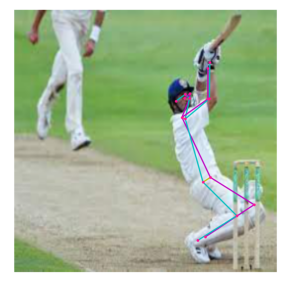

In [34]:
example(0) #this will take the data from the above array X

fielding


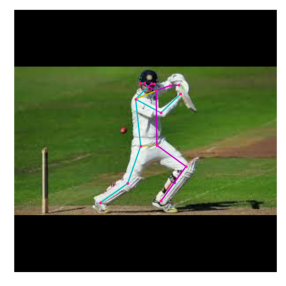

In [35]:
path=str(cut[10]) 
example(path) #this is the specified path 